Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0146 - val_loss: 0.0023
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.4860e-04 - val_loss: 9.5778e-04
Epoch 10/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 11/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.0850e-04 - val_loss: 8.2179e-04
Epoch 12/200
46/46 ━━━━━━━━━━━━━━━━━

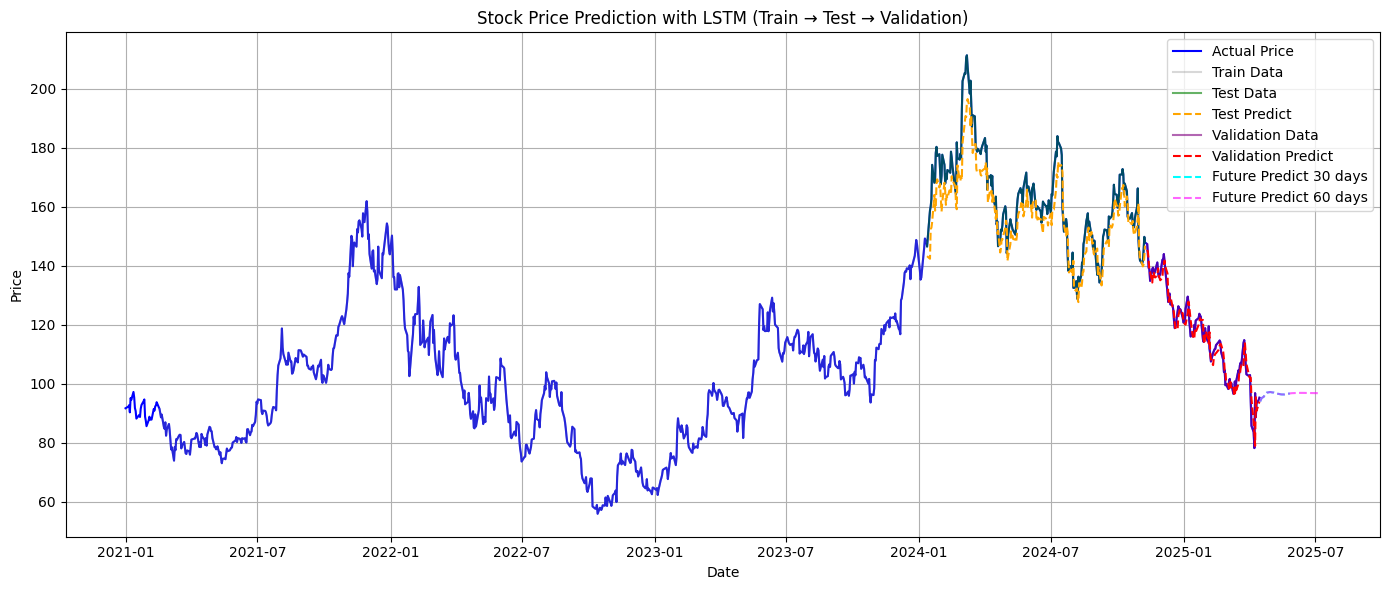

Test MAE: 6.0867
Test RMSE: 7.5700
Test MAPE: 3.64%

Validation MAE: 2.7324
Validation RMSE: 3.7048
Validation MAPE: 2.46%



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Đọc dữ liệu
file_path = "../../Dataset/amd_stock_price.csv"
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date").reset_index(drop=True)

# Xử lý Volume và Change %
def parse_volume(vol):
    if isinstance(vol, str):
        if 'M' in vol:
            return float(vol.replace('M', '').replace(',', '')) * 1e6
        elif 'B' in vol:
            return float(vol.replace('B', '').replace(',', '')) * 1e9
    return np.nan

df["Vol."] = df["Vol."].apply(parse_volume)
df["Change %"] = df["Change %"].str.replace('%', '').astype(float)

# Giữ Date lại
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
df = df[['Date'] + features].dropna()

# Chuẩn hóa
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[features])

# Tạo chuỗi thời gian
window_size = 30
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i - window:i])
        y.append(data[i, 0])  # Price
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data_scaled, window_size)

# Chia dữ liệu theo: Train -> Test -> Validation
n_samples = X_all.shape[0]
train_size = int(n_samples * 0.7)
test_size = int(n_samples * 0.2)
val_size = n_samples - train_size - test_size

X_train = X_all[:train_size]
y_train = y_all[:train_size]

X_test = X_all[train_size:train_size + test_size]
y_test = y_all[train_size:train_size + test_size]

X_val = X_all[train_size + test_size:]
y_val = y_all[train_size + test_size:]

# Mô hình
model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),
    LSTM(100, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Huấn luyện
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=200, batch_size=16,
          validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

# Chuẩn hóa nghịch biến chỉ Price
price_scaler = MinMaxScaler()
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Dự đoán

y_pred_val = model.predict(X_val)
y_val_true = price_scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val = price_scaler.inverse_transform(y_pred_val)

y_pred_test = model.predict(X_test)
y_test_true = price_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test = price_scaler.inverse_transform(y_pred_test)

# Dự đoán tương lai

def predict_future(days, last_sequence):
    preds = []
    for _ in range(days):
        pred_scaled = model.predict(last_sequence)
        preds.append(pred_scaled[0, 0])
        next_input = last_sequence.copy()
        next_input = np.roll(next_input, -1, axis=1)
        next_input[0, -1, :] = last_sequence[0, -1, :]
        next_input[0, -1, 0] = pred_scaled[0, 0]
        last_sequence = next_input
    return price_scaler.inverse_transform(np.array(preds).reshape(-1, 1))

future_preds_30 = predict_future(30, X_val[-1:])
future_preds_60 = predict_future(60, X_val[-1:])

# Chuẩn bị vẽ

dates = df["Date"].values
train_dates = dates[window_size : window_size + train_size]
test_dates = dates[window_size + train_size : window_size + train_size + test_size]
val_dates = dates[window_size + train_size + test_size : window_size + n_samples]

future_start = df["Date"].iloc[-1]
future_dates_30 = pd.date_range(future_start, periods=30 + 1, freq='B')[1:]
future_dates_60 = pd.date_range(future_start, periods=60 + 1, freq='B')[1:]

plt.figure(figsize=(14, 6))
plt.plot(dates, df["Price"], label='Actual Price', color='blue')
plt.plot(train_dates, price_scaler.inverse_transform(y_train.reshape(-1, 1)), label='Train Data', color='gray', alpha=0.3)
plt.plot(test_dates, y_test_true, label='Test Data', color='green', alpha=0.6)
plt.plot(test_dates, y_pred_test, label='Test Predict', linestyle='--', color='orange')
plt.plot(val_dates, y_val_true, label='Validation Data', color='purple', alpha=0.6)
plt.plot(val_dates, y_pred_val, label='Validation Predict', linestyle='--', color='red')
plt.plot(future_dates_30, future_preds_30, label='Future Predict 30 days', linestyle='--', color='cyan')
plt.plot(future_dates_60, future_preds_60, label='Future Predict 60 days', linestyle='--', color='magenta', alpha=0.6)

plt.title("Stock Price Prediction with LSTM (Train → Test → Validation)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Đánh giá

def evaluate(y_true, y_pred, label=''):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{label} MAE: {mae:.4f}")
    print(f"{label} RMSE: {rmse:.4f}")
    print(f"{label} MAPE: {mape*100:.2f}%\n")

evaluate(y_test_true, y_pred_test, "Test")
evaluate(y_val_true, y_pred_val, "Validation")
